In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

import glob
import PIL
from PIL import Image


2024-05-29 09:24:14.618631: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 09:24:14.618736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 09:24:14.781136: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import glob
import random
import shutil

advertising_folder = r"/kaggle/input/advertisement-images/Images/Advertising Images"

non_advertising_folder = r"/kaggle/input/advertisement-images/Images/Non-Advertising Images"


# Load all advertising images and randomly select 2500
advertising_images = glob.glob(os.path.join(advertising_folder, "*.jpg"))
random.shuffle(advertising_images)
selected_advertising_images = advertising_images[:2500]

# Combine selected advertising images with all non-advertising images
all_images = selected_advertising_images + glob.glob(os.path.join(non_advertising_folder, "*.jpg"))
random.shuffle(all_images)

print("Total number of images:", len(all_images))


Total number of images: 3166


In [3]:
all_images[20:50]

['/kaggle/input/advertisement-images/Images/Advertising Images/advertising_325_1.jpg',
 '/kaggle/input/advertisement-images/Images/Advertising Images/advertising_2188.jpg',
 '/kaggle/input/advertisement-images/Images/Advertising Images/advertising_4027.jpg',
 '/kaggle/input/advertisement-images/Images/Non-Advertising Images/non_advertising_317.jpg',
 '/kaggle/input/advertisement-images/Images/Advertising Images/advertising_3000.jpg',
 '/kaggle/input/advertisement-images/Images/Non-Advertising Images/non_advertising_461.jpg',
 '/kaggle/input/advertisement-images/Images/Advertising Images/advertising_2143.jpg',
 '/kaggle/input/advertisement-images/Images/Non-Advertising Images/non_advertising_666.jpg',
 '/kaggle/input/advertisement-images/Images/Advertising Images/advertising_2158.jpg',
 '/kaggle/input/advertisement-images/Images/Non-Advertising Images/non_advertising_121.jpg',
 '/kaggle/input/advertisement-images/Images/Advertising Images/advertising_1881.jpg',
 '/kaggle/input/advertise

In [4]:
import cv2

In [5]:
import numpy as np

In [6]:
import imgaug.augmenters as iaa

In [7]:
from sklearn.utils import shuffle

In [8]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),        # horizontally flip 50% of images
    iaa.Flipud(0.5),        # vertically flip 50% of images
    iaa.Rotate((-20, 20)),  # rotate images by -20 to +20 degrees
    iaa.GaussianBlur(sigma=(0, 1.0))  # apply gaussian blur
])


In [9]:
# Function to preprocess and augment images
def preprocess_images(image_paths, target_size=(224, 224), normalize=True, augmentation=None):
    images = []
    for image_path in image_paths:
        # Load image
        image = cv2.imread(image_path)
        # Resize image
        image = cv2.resize(image, target_size)
        # Augment image
        if augmentation is not None:
            image = augmentation(image=image)
        # Convert image to float32
        image = image.astype(np.float32)
        # Normalize image
        if normalize:
            image /= 255.0  # Normalize pixel values to [0, 1]
        images.append(image)
    return np.array(images)

# Preprocess and augment all images
X = preprocess_images(all_images, augmentation=augmentation)  # Preprocess and augment images

# To Check the shape of the preprocessed images array
print("Shape of preprocessed images array:", X.shape)

Shape of preprocessed images array: (3166, 224, 224, 3)


In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
# Extract category labels from file names
def extract_labels(file_paths):
    labels = []
    for file_path in file_paths:
        label = file_path.split("/")[-2]  # Extract label from file path
        labels.append(label)
    return labels

In [12]:
# Encode category labels using LabelEncoder
def encode_labels(labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    return encoded_labels, label_encoder.classes_

In [13]:
# Get category labels
labels = extract_labels(all_images)

# Encode category labels
y_encoded, classes = encode_labels(labels)

# Print the encoded labels and their corresponding classes
print("Encoded labels:", len(y_encoded))
print("Corresponding classes:", classes)

Encoded labels: 3166
Corresponding classes: ['Advertising Images' 'Non-Advertising Images']


In [14]:
import numpy as np
from sklearn.model_selection import train_test_split

In [15]:
# Convert lists to NumPy arrays
all_images = np.array(all_images)
y_encoded = np.array(y_encoded)

# Split the dataset into training, testing, and validation sets
# First, split into training and temporary sets (80% training, 20% temporary)
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Second, split the temporary set into testing and validation sets (50% testing, 50% validation)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Print the shapes of the resulting datasets
print("Training set shape:", X_train_temp.shape, y_train_temp.shape)
print("Testing set shape:", X_test.shape, y_test.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

Training set shape: (2532, 224, 224, 3) (2532,)
Testing set shape: (317, 224, 224, 3) (317,)
Validation set shape: (317, 224, 224, 3) (317,)


In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:

# Initialize StandardScaler
scaler = StandardScaler()

# Define batch size for incremental scaling
batch_size = 500

# Initialize empty arrays to store scaled data
X_train_scaled = np.empty_like(X_train_temp)
X_test_scaled = np.empty_like(X_test)
X_val_scaled = np.empty_like(X_val)

# Incrementally scale training data
for i in range(0, len(X_train_temp), batch_size):
    batch_X_train = X_train_temp[i:i+batch_size]
    batch_X_train_flat = batch_X_train.reshape(batch_X_train.shape[0], -1)
    scaler.partial_fit(batch_X_train_flat)
    batch_X_train_scaled = scaler.transform(batch_X_train_flat)
    X_train_scaled[i:i+batch_size] = batch_X_train_scaled.reshape(batch_X_train.shape)

# Incrementally scale testing data
for i in range(0, len(X_test), batch_size):
    batch_X_test = X_test[i:i+batch_size]
    batch_X_test_flat = batch_X_test.reshape(batch_X_test.shape[0], -1)
    batch_X_test_scaled = scaler.transform(batch_X_test_flat)
    X_test_scaled[i:i+batch_size] = batch_X_test_scaled.reshape(batch_X_test.shape)

# Incrementally scale validation data
for i in range(0, len(X_val), batch_size):
    batch_X_val = X_val[i:i+batch_size]
    batch_X_val_flat = batch_X_val.reshape(batch_X_val.shape[0], -1)
    batch_X_val_scaled = scaler.transform(batch_X_val_flat)
    X_val_scaled[i:i+batch_size] = batch_X_val_scaled.reshape(batch_X_val.shape)

# Print the shape of the scaled data
print("Shape of scaled training data:", X_train_scaled.shape)
print("Shape of scaled testing data:", X_test_scaled.shape)
print("Shape of scaled validation data:", X_val_scaled.shape)


Shape of scaled training data: (2532, 224, 224, 3)
Shape of scaled testing data: (317, 224, 224, 3)
Shape of scaled validation data: (317, 224, 224, 3)


In [18]:
from tensorflow.keras.applications import VGG16

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [20]:

# Load pre-trained VGG16 model without the top layers
base_model = VGG16(weights=r'/kaggle/input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout layer with a dropout rate of 0.5
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,89

 Total params: 27,724,609 (105.76 MB)

 Trainable params: 13,009,921 (49.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
]

# Train the model
history = model.fit(X_train_scaled, y_train_temp,
                    epochs=25,
                    batch_size=128,  # Increased batch size
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

print("Model training completed and best model saved as 'best_model.keras'.")


Epoch 1/25


2024-05-29 09:26:13.240684: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[128,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-29 09:26:13.315918: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.07534794s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[128,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}

19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.7464 - loss: 0.5536

W0000 00:00:1716974950.418760     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7488 - loss: 0.5491   

W0000 00:00:1716974952.280049     144 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716975007.509485     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 255s 8s/step - accuracy: 0.7511 - loss: 0.5450 - val_accuracy: 0.8991 - val_loss: 0.2759
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 651ms/step - accuracy: 0.9016 - loss: 0.2381 - val_accuracy: 0.8864 - val_loss: 0.2711
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 596ms/step - accuracy: 0.9374 - loss: 0.1598 - val_accuracy: 0.8675 - val_loss: 0.3291
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 598ms/step - accuracy: 0.9472 - loss: 0.1365 - val_accuracy: 0.8801 - val_loss: 0.3256
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 600ms/step - accuracy: 0.9687 - loss: 0.1003 - val_accuracy: 0.9054 - val_loss: 0.2831
Model training completed and best model saved as 'best_model.keras'.


In [22]:
# Save the best model manually in the .h5 format
best_model_path = r'/kaggle/working/best_model.keras'
model.load_weights(best_model_path)
model.save('best_model.h5')

print("Best model saved in the .h5 format as 'best_model.h5'.")


Best model saved in the .h5 format as 'best_model.h5'.


In [23]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


 1/10 ━━━━━━━━━━━━━━━━━━━━ 4:31 30s/step - accuracy: 0.9375 - loss: 0.1675

W0000 00:00:1716975092.035550     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9562 - loss: 0.1288 
Test Loss: 0.10026855021715164
Test Accuracy: 0.965299665927887


W0000 00:00:1716975120.621966     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

pScore = precision_score(y_true= y_test, y_pred = y_pred, average = 'weighted')
print("Precision: ", pScore)

rScore = recall_score(y_true= y_test, y_pred = y_pred, average = 'weighted')
print("Recall: ", rScore)

fScore = f1_score(y_true= y_test, y_pred = y_pred, average = 'weighted')
print("F1-score: ", fScore)

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

W0000 00:00:1716975121.888618     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step
Precision:  0.9649700440144139
Recall:  0.9652996845425867
F1-score:  0.9650058327521804


W0000 00:00:1716975123.532056     144 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Function to plot precision-recall curve
def plot_precision_recall_curve(y_true, y_score):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()


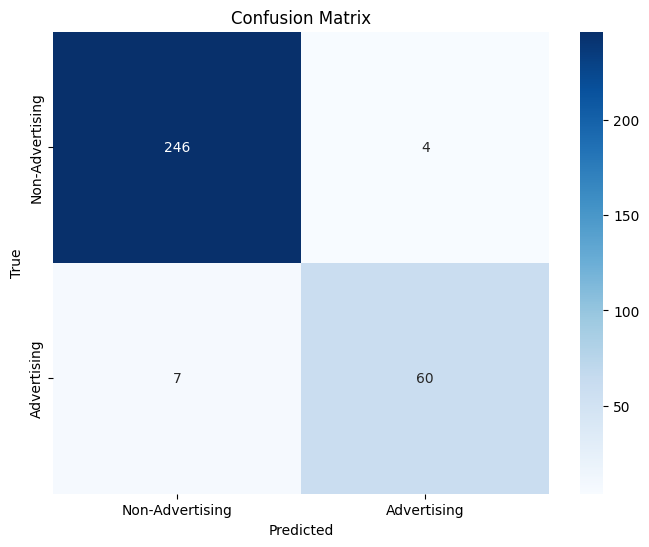

In [26]:
# To plot confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=['Non-Advertising', 'Advertising'])

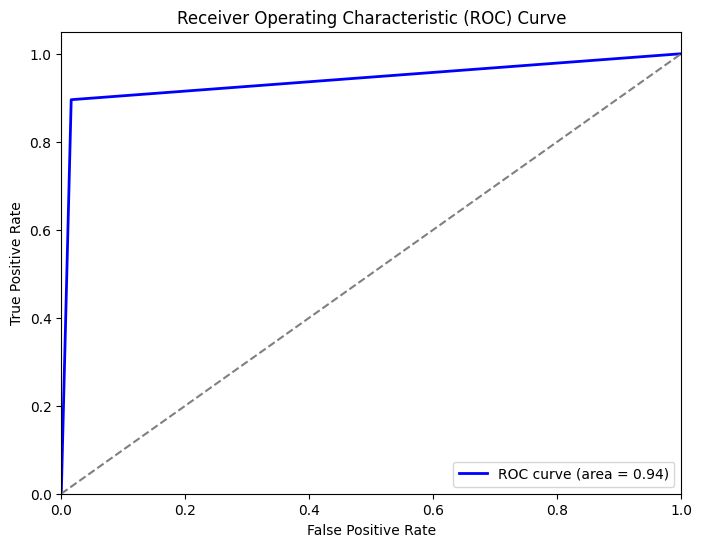

In [27]:
# To plot ROC curve
plot_roc_curve(y_test, y_pred)

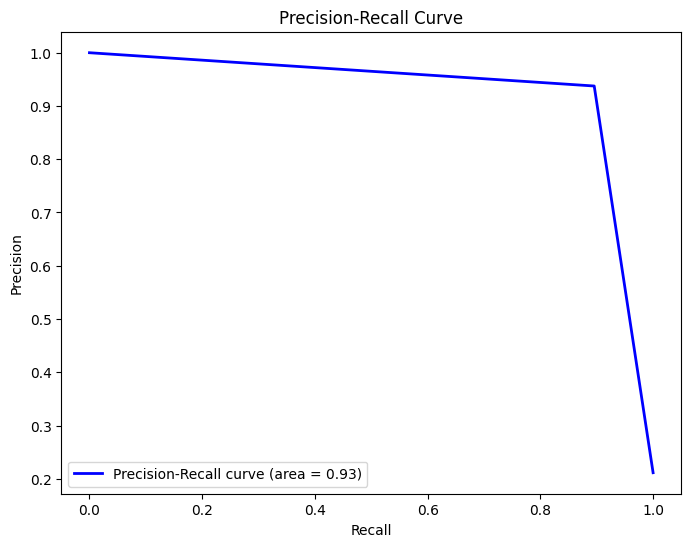

In [28]:
# To plot precision-recall curve
plot_precision_recall_curve(y_test, y_pred)